In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"         # Disable GPU use
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"          # Suppress TensorFlow logs

import tensorflow as tf
import tensorflow_hub as hub
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [2]:
model = hub.load('https://tfhub.dev/google/movenet/multipose/lightning/1')
movenet = model.signatures['serving_default']

In [13]:
# cap = cv2.VideoCapture(0)
cap = cv2.VideoCapture('novak.mp4')
while cap.isOpened():
    ret, frame = cap.read()
    
    # Resize image
    img = frame.copy()
    img = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 384,640)
    input_img = tf.cast(img, dtype=tf.int32)
    
    # Detection section
    results = movenet(input_img)
    keypoints_with_scores = results['output_0'].numpy()[:,:,:51].reshape((6,17,3))
    
    # Render keypoints 
    loop_through_people(frame, keypoints_with_scores, EDGES, 0.1)
    
    cv2.imshow('Movenet Multipose', frame)
    
    if cv2.waitKey(10) & 0xFF==ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
results['output_0'].numpy()[:,:,:5]

array([[[0.5603644 , 0.57458884, 0.6327475 , 0.50337917, 0.63640344],
        [0.4281702 , 0.01574322, 0.04741555, 0.42207554, 0.01935427],
        [0.69161016, 0.22639006, 0.01497059, 0.6818419 , 0.22749703],
        [0.5603644 , 0.57458884, 0.6327475 , 0.50337917, 0.63640344],
        [0.92284083, 0.9779984 , 0.03099799, 0.85205114, 0.9310433 ],
        [0.82657766, 0.94452876, 0.01698354, 0.82003367, 0.9419357 ]]],
      dtype=float32)

In [5]:
keypoints_with_scores[0]

array([[5.6036443e-01, 5.7458884e-01, 6.3274747e-01],
       [5.0337917e-01, 6.3640344e-01, 4.3669730e-01],
       [4.7570682e-01, 4.9316651e-01, 6.4043909e-01],
       [5.6187594e-01, 6.8575639e-01, 6.3679099e-01],
       [5.1443851e-01, 3.5884485e-01, 5.4136783e-01],
       [8.5305852e-01, 7.9035008e-01, 3.5578772e-01],
       [8.1786883e-01, 1.4565712e-01, 2.4927878e-01],
       [8.6995906e-01, 8.1541312e-01, 4.4592608e-02],
       [8.5873365e-01, 3.7782494e-02, 3.8749613e-02],
       [7.5757742e-01, 6.8561590e-01, 5.2963242e-02],
       [7.1338981e-01, 1.4500223e-01, 6.5954342e-02],
       [8.7837565e-01, 5.3138107e-01, 6.6455534e-05],
       [8.6102217e-01, 2.5189987e-01, 7.8469185e-07],
       [7.2226161e-01, 7.5723267e-01, 1.5671058e-02],
       [6.7850190e-01, 4.2730987e-01, 4.2009328e-02],
       [2.3830080e-01, 6.2617600e-01, 4.0350822e-03],
       [2.5931501e-01, 4.7252789e-01, 4.0833354e-03]], dtype=float32)

In [6]:
# Function to loop through each person detected and render
def loop_through_people(frame, keypoints_with_scores, edges, confidence_threshold):
    for person in keypoints_with_scores:
        draw_connections(frame, person, edges, confidence_threshold)
        draw_keypoints(frame, person, confidence_threshold)

In [7]:
frame

array([[[164, 157, 170],
        [165, 159, 171],
        [173, 167, 179],
        ...,
        [238, 211, 222],
        [226, 207, 217],
        [214, 195, 205]],

       [[165, 159, 171],
        [166, 160, 172],
        [170, 166, 178],
        ...,
        [220, 201, 204],
        [215, 202, 206],
        [216, 203, 208]],

       [[163, 161, 168],
        [165, 163, 170],
        [169, 168, 170],
        ...,
        [218, 199, 208],
        [210, 204, 216],
        [208, 202, 214]],

       ...,

       [[145, 109, 147],
        [148, 113, 150],
        [136, 119, 150],
        ...,
        [108, 100, 124],
        [108,  90, 136],
        [100,  82, 128]],

       [[129, 118, 131],
        [136, 125, 138],
        [130, 128, 135],
        ...,
        [ 97,  96, 114],
        [107, 107, 134],
        [115, 115, 143]],

       [[125, 137, 142],
        [125, 137, 142],
        [131, 136, 135],
        ...,
        [122,  97, 117],
        [108, 116, 133],
        [109, 117, 134]]

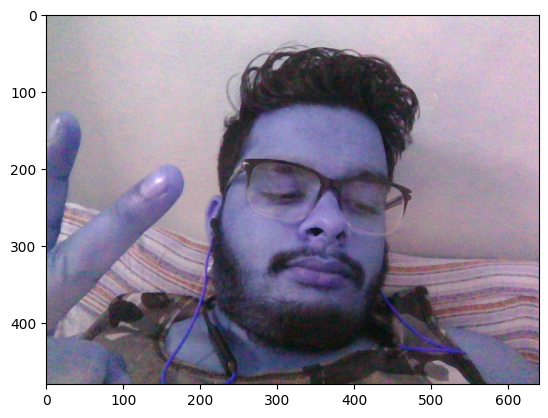

In [8]:
plt.imshow(frame)

In [9]:
def draw_keypoints(frame, keypoints, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for kp in shaped:
        ky, kx, kp_conf = kp
        if kp_conf > confidence_threshold:
            cv2.circle(frame, (int(kx), int(ky)), 6, (0,255,0), -1)

In [10]:
EDGES = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

In [11]:
def draw_connections(frame, keypoints, edges, confidence_threshold):
    y, x, c = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, color in edges.items():
        p1, p2 = edge
        y1, x1, c1 = shaped[p1]
        y2, x2, c2 = shaped[p2]
        
        if (c1 > confidence_threshold) & (c2 > confidence_threshold):      
            cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (0,0,255), 4)